In [88]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier    #tree based ensemble algorithm
import catboost as cat
from catboost import CatBoostClassifier    #boosting algorithm
from lightgbm import LGBMClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import StratifiedKFold   #for cross validation
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score   #classification metrics
import xgboost as xgb

In [51]:
#importing files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    Mean value of the column is used for numerical column while the
    modal category is used for categorical columns
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data

In [4]:
def freq_encoding(traindata, testdata, *args):
    
    '''
    Freq encoding is used to encode a categorical variable
    The link sent should be consulted to understand when to use 
    '''
    
    for _ in args:
        train_enc = (traindata.groupby(_).size()) / len(traindata)
        test_enc = (testdata.groupby(_).size()) / len(testdata)
        
        traindata[_] = traindata[_].apply(lambda x: train_enc[x])
        testdata[_] = testdata[_].apply(lambda x: test_enc[x])
    
    return traindata, testdata

In [5]:
def one_hot_encoding(traindata, testdata, *args):
    
    '''
    For encoding categorical variables. pd.get_dummies() is used.
    Other one hot encoding techniques are available too.
    Kindly consult the links dropped on the group chat to find out more on how it works
    '''
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        testdata = pd.get_dummies(testdata, prefix=[ii], columns=[ii])
        
    return traindata, testdata

In [6]:
def drop_columns(traindata, testdata, target, *args):
    
    '''
    Function to drop unwanted columns based on user's reasons
    
    Takes in the train data and the test data and the target columns title
    and a list of columns to be dropped
    '''
    
    labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    traindata = traindata.drop(target, axis=1)
    testdata = testdata.drop(columns, axis=1)
        
    return labels, traindata, testdata

# Exploratory Data Analysis

In [7]:
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [8]:
train.shape, test.shape

((400000, 19), (100000, 18))

In [9]:
#check missing values

train.isna().sum()

user_id                0
REGION            157520
TENURE                 0
MONTANT           140277
FREQUENCE_RECH    140277
REVENUE           134663
ARPU_SEGMENT      134663
FREQUENCE         134663
DATA_VOLUME       196854
ON_NET            145819
ORANGE            166317
TIGO              239386
ZONE1             368310
ZONE2             374487
MRG                    0
REGULARITY             0
TOP_PACK          167329
FREQ_TOP_PACK     167329
CHURN                  0
dtype: int64

In [10]:
test.isna().sum()

user_id               0
REGION            39293
TENURE                0
MONTANT           34951
FREQUENCE_RECH    34951
REVENUE           33490
ARPU_SEGMENT      33490
FREQUENCE         33490
DATA_VOLUME       49338
ON_NET            36383
ORANGE            41200
TIGO              59788
ZONE1             92320
ZONE2             93578
MRG                   0
REGULARITY            0
TOP_PACK          41703
FREQ_TOP_PACK     41703
dtype: int64

In [11]:
train.describe()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
count,259723.000000,259723.000000,265337.000000,265337.000000,265337.000000,203146.000000,254181.000000,233683.000000,160614.000000,31690.000000,25513.000000,400000.000000,232671.000000,400000.00000
mean,5522.971346,11.503733,5505.487757,1835.167658,13.951835,3369.763441,275.917586,95.532927,23.134608,7.874282,7.187003,28.046502,9.254209,0.18711
std,7099.640630,13.275514,7175.802367,2391.929290,14.679943,12281.867504,873.593034,204.733272,63.061871,35.642843,26.964028,22.282773,12.305563,0.39000
min,20.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000
25%,1000.000000,2.000000,1000.000000,333.000000,3.000000,0.000000,5.000000,7.000000,2.000000,0.000000,0.000000,6.000000,2.000000,0.00000
50%,3000.000000,6.000000,3000.000000,1000.000000,9.000000,267.000000,27.000000,29.000000,6.000000,1.000000,2.000000,24.000000,5.000000,0.00000
75%,7300.000000,15.000000,7340.000000,2447.000000,19.000000,2925.000000,155.000000,99.000000,20.000000,3.000000,5.000000,51.000000,12.000000,0.00000
max,226550.000000,133.000000,233413.000000,77804.000000,91.000000,934576.000000,45011.000000,6788.000000,2758.000000,1657.000000,1011.000000,62.000000,629.000000,1.00000


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         400000 non-null  object 
 1   REGION          242480 non-null  object 
 2   TENURE          400000 non-null  object 
 3   MONTANT         259723 non-null  float64
 4   FREQUENCE_RECH  259723 non-null  float64
 5   REVENUE         265337 non-null  float64
 6   ARPU_SEGMENT    265337 non-null  float64
 7   FREQUENCE       265337 non-null  float64
 8   DATA_VOLUME     203146 non-null  float64
 9   ON_NET          254181 non-null  float64
 10  ORANGE          233683 non-null  float64
 11  TIGO            160614 non-null  float64
 12  ZONE1           31690 non-null   float64
 13  ZONE2           25513 non-null   float64
 14  MRG             400000 non-null  object 
 15  REGULARITY      400000 non-null  int64  
 16  TOP_PACK        232671 non-null  object 
 17  FREQ_TOP_P

In [13]:
train.describe()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
count,259723.000000,259723.000000,265337.000000,265337.000000,265337.000000,203146.000000,254181.000000,233683.000000,160614.000000,31690.000000,25513.000000,400000.000000,232671.000000,400000.00000
mean,5522.971346,11.503733,5505.487757,1835.167658,13.951835,3369.763441,275.917586,95.532927,23.134608,7.874282,7.187003,28.046502,9.254209,0.18711
std,7099.640630,13.275514,7175.802367,2391.929290,14.679943,12281.867504,873.593034,204.733272,63.061871,35.642843,26.964028,22.282773,12.305563,0.39000
min,20.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000
25%,1000.000000,2.000000,1000.000000,333.000000,3.000000,0.000000,5.000000,7.000000,2.000000,0.000000,0.000000,6.000000,2.000000,0.00000
50%,3000.000000,6.000000,3000.000000,1000.000000,9.000000,267.000000,27.000000,29.000000,6.000000,1.000000,2.000000,24.000000,5.000000,0.00000
75%,7300.000000,15.000000,7340.000000,2447.000000,19.000000,2925.000000,155.000000,99.000000,20.000000,3.000000,5.000000,51.000000,12.000000,0.00000
max,226550.000000,133.000000,233413.000000,77804.000000,91.000000,934576.000000,45011.000000,6788.000000,2758.000000,1657.000000,1011.000000,62.000000,629.000000,1.00000


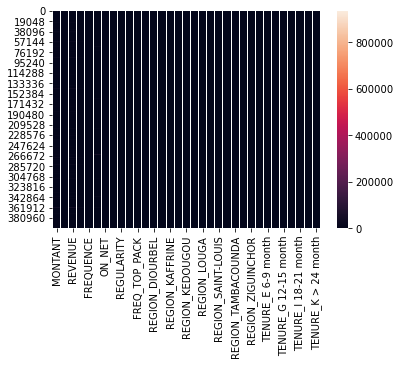

In [46]:
sns.heatmap(train1)

Other plot visualizations should be employed to explore data patterns

# Data Preparation 

In [52]:
cols = ['ZONE1', 'ZONE2', 'TIGO', 'user_id', 'MRG']   #columns to be dropped
#columns are dropped because there are too many missing values in such columns(greater than 50%)
#MRG column is dropped because it contains only a single category, hence useless
#user_id  ` ` ` ` ` ` ` ` ` ` ` it contains unique ids throughout, useless too

labels, train1, test1 = drop_columns(train, test, 'CHURN', *cols)

In [53]:
#the remaining columns with missing values were filled using the function defined above
#refer back to the function to have an idea of what's going on

train1 = fill_missing_values(train1)    
test1 = fill_missing_values(test1)

In [54]:
#one hot enciding on the categrical variables

one_hot_cols = ['REGION', 'TENURE']

train1, test1 = one_hot_encoding(train1, test1, *one_hot_cols)

In [55]:
#freq encoding on TOP PACK column due to it's nature of many categorical types

freq_col = ['TOP_PACK']

train1, test1 = freq_encoding(train1, test1, *freq_col)

In [56]:
train2 = train1.copy()
test2 = test1.copy()

# Feature Engineering

FEature engineering on the numericalfeatures and feature generations

In [57]:
#Features should be generated based on intuition, trial and error can be employed too

train2['REV_DATA_VOL'] = train2['REVENUE'] * train2['DATA_VOLUME']
#train2['LOG_DATA_VOL'] = np.log(train2['DATA_VOLUME'])

test2['REV_DATA_VOL'] = test2['REVENUE'] * test2['DATA_VOLUME']
#test2['LOG_DATA_VOL'] = np.log(test2['DATA_VOLUME'])

In [77]:
features1

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,TOP_PACK,...,REGION_ZIGUINCHOR,TENURE_D 3-6 month,TENURE_E 6-9 month,TENURE_F 9-12 month,TENURE_G 12-15 month,TENURE_H 15-18 month,TENURE_I 18-21 month,TENURE_J 21-24 month,TENURE_K > 24 month,REV_DATA_VOL
0,17000.000000,32.000000,18000.000000,6000.000000,34.000000,3369.763441,97.000000,355.000000,62,0.565010,...,0,0,0,0,0,0,0,0,1,6.065574e+07
1,4300.000000,29.000000,4427.000000,1476.000000,37.000000,1764.000000,8.000000,3.000000,40,0.038975,...,0,0,0,0,0,0,0,0,1,7.809228e+06
2,1500.000000,3.000000,1500.000000,500.000000,3.000000,3369.763441,30.000000,30.000000,32,0.565010,...,0,0,0,0,0,0,0,0,1,5.054645e+06
3,1500.000000,3.000000,2497.000000,832.000000,4.000000,0.000000,159.000000,45.000000,18,0.070968,...,0,0,0,0,0,0,0,0,1,0.000000e+00
4,5522.971346,11.503733,498.000000,166.000000,3.000000,1.000000,1.000000,3.000000,50,0.565010,...,0,0,0,0,0,0,0,0,1,4.980000e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,700.000000,2.000000,704.000000,235.000000,3.000000,3369.763441,12.000000,14.000000,46,0.565010,...,0,0,0,0,0,0,0,0,1,2.372313e+06
399996,5522.971346,11.503733,5505.487757,1835.167658,13.951835,3369.763441,275.917586,95.532927,14,0.565010,...,0,0,0,0,0,0,0,0,1,1.855219e+07
399997,700.000000,2.000000,699.000000,233.000000,5.000000,237.000000,1.000000,95.532927,15,0.038975,...,0,0,0,0,0,0,0,0,1,1.656630e+05
399998,5522.971346,11.503733,9.000000,3.000000,1.000000,0.000000,275.917586,0.000000,5,0.565010,...,0,0,0,0,0,0,0,0,1,0.000000e+00


In [76]:
features1 = (train2)
test_enc1 = (test2)

In [60]:
#Scaling the features to be a normal distribution

#using StandardScaler function to scale the numeric features 

scaler = preprocessing.StandardScaler().fit(features1[:, :])
features1[:, :] = scaler.transform(features1[:, :])
features1[:, :]

array([[ 2.00617459e+00,  1.91601564e+00,  2.13786730e+00, ...,
        -7.64622958e-02,  2.32782931e-01,  1.01675431e-01],
       [-2.13774324e-01,  1.63557204e+00, -1.84534111e-01, ...,
        -7.64622958e-02,  2.32782931e-01, -8.28982073e-02],
       [-7.03211881e-01, -7.94939145e-01, -6.85356990e-01, ...,
        -7.64622958e-02,  2.32782931e-01, -9.25189626e-02],
       ...,
       [-8.43051183e-01, -8.88420345e-01, -8.22411696e-01, ...,
        -7.64622958e-02,  2.32782931e-01, -1.09594398e-01],
       [ 0.00000000e+00,  0.00000000e+00, -9.40473803e-01, ...,
        -7.64622958e-02,  2.32782931e-01, -1.10172998e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.55618638e-16, ...,
        -7.64622958e-02,  2.32782931e-01, -4.53769465e-02]])

In [79]:
X_train

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,TOP_PACK,...,REGION_ZIGUINCHOR,TENURE_D 3-6 month,TENURE_E 6-9 month,TENURE_F 9-12 month,TENURE_G 12-15 month,TENURE_H 15-18 month,TENURE_I 18-21 month,TENURE_J 21-24 month,TENURE_K > 24 month,REV_DATA_VOL
398856,5522.971346,11.503733,18.000000,6.000000,1.000000,3369.763441,0.000000,95.532927,8,0.565010,...,0,0,0,0,0,0,0,0,1,6.065574e+04
216459,5522.971346,11.503733,5505.487757,1835.167658,13.951835,3369.763441,275.917586,95.532927,1,0.565010,...,0,0,0,0,0,0,0,0,1,1.855219e+07
294451,1000.000000,5.000000,823.000000,274.000000,10.000000,207.000000,1.000000,8.000000,37,0.038975,...,0,0,0,0,0,0,0,0,1,1.703610e+05
91169,5522.971346,11.503733,5505.487757,1835.167658,13.951835,3369.763441,275.917586,95.532927,2,0.565010,...,0,0,0,0,0,0,0,0,1,1.855219e+07
25120,100.000000,1.000000,99.000000,33.000000,1.000000,0.000000,275.917586,1.000000,5,0.565010,...,1,0,0,0,0,0,0,0,1,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1000.000000,2.000000,1000.000000,333.000000,2.000000,914.000000,152.000000,2.000000,29,0.565010,...,0,0,0,0,0,0,0,0,1,9.140000e+05
365838,7500.000000,15.000000,8000.000000,2667.000000,16.000000,0.000000,50.000000,133.000000,62,0.565010,...,0,0,0,0,0,0,0,0,1,0.000000e+00
131932,200.000000,1.000000,166.000000,55.000000,2.000000,233.000000,7.000000,1.000000,4,0.565010,...,0,0,0,0,0,0,0,0,1,3.867800e+04
146867,2500.000000,5.000000,2500.000000,833.000000,5.000000,3369.763441,89.000000,63.000000,50,0.565010,...,0,0,0,0,0,0,0,0,1,8.424409e+06


In [78]:


X_train, X_test, Y_train, Y_test = ms.train_test_split(features1, labels, test_size=0.33, random_state=42)

In [37]:
from sklearn.linear_model import LogisticRegression

In [63]:
lr = LogisticRegression(C=10)
lr.fit(X_train, Y_train)

LogisticRegression(C=10)

In [64]:
#Using prediction probabilities

test_pred_proba = lr.predict_proba(X_test)
test_pred = lr.predict(X_test)

In [65]:
test_pred.shape, test_pred_proba.shape

((132000,), (132000, 2))

In [66]:
test_pred[:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [67]:
needed_prediction = test_pred_proba[:,1]

In [68]:
needed_prediction[:10]

array([2.88591719e-03, 8.88896546e-04, 6.95501920e-02, 6.49020616e-04,
       4.16955073e-01, 6.20250817e-01, 2.00904436e-03, 9.15394100e-04,
       4.75272994e-04, 5.43763361e-01])

# Evaluation

In [44]:
log_loss(test_pred, Y_test)

4.605741549318442

# KFOLD CROSS VALIDATION

LOCAL TESTING AND VALIDATION

In [91]:
nsplit=5

kf = StratifiedKFold(n_splits=nsplit,shuffle=True)
#model = LGBMClassifier(max_depth=8, num_leaves=64, boosting_type='gbdt',learning_rate=0.01, reg_alpha=10, n_estimators=50000,subsample=0.9, colsample_bytree=0.9, random_state=2)
#model = CatBoostClassifier(n_estimators=50000, max_depth=8, random_state=14, learning_rate=0.033,use_best_model=True, task_type='CPU', eval_metric='AUC')
model = xgb.XGBClassifier(n_estimators=5000, max_depth=8, booster='gbtree', base_score=0.7,
                     learning_rate=0.033, reg_lambda=30,
                     subsample=0.9, colsample_bytree=0.9,
                     eval_metric='auc', random_state=20920)

pred_test2 = np.zeros((len(X_test), 2))
for (train_index,test_index) in kf.split(pd.DataFrame(X_train),pd.DataFrame(Y_train)):
    x_train,x_test = pd.DataFrame(X_train).iloc[train_index], pd.DataFrame(X_train).iloc[test_index]
    y_train,y_test = pd.DataFrame(Y_train).iloc[train_index],pd.DataFrame(Y_train).iloc[test_index]
    model.fit(x_train, y_train ,early_stopping_rounds=100,
              eval_set=[(x_test, y_test)], verbose=50)
    pred_test2+=model.predict_proba(X_test)

/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0]	validation_0-auc:0.87554
Will train until validation_0-auc hasn't improved in 100 rounds.
[9]	validation_0-auc:0.91421
[0]	validation_0-auc:0.87744
Will train until validation_0-auc hasn't improved in 100 rounds.
[9]	validation_0-auc:0.91510
[0]	validation_0-auc:0.87504
Will train until validation_0-auc hasn't improved in 100 rounds.
[9]	validation_0-auc:0.91339
[0]	validation_0-auc:0.87619
Will train until validation_0-auc hasn't improved in 100 rounds.
[9]	validation_0-auc:0.91313
[0]	validation_0-auc:0.87940
Will train until validation_0-auc hasn't improved in 100 rounds.
[9]	validation_0-auc:0.91502


In [83]:
pred_test_avg = pred_test2/nsplit
pred_test2 = pred_test_avg[:,1]
pred_test2[:20]

array([0.52703109, 0.52548623, 0.53086146, 0.52548623, 0.63413075,
       0.69030105, 0.52869693, 0.52621469, 0.52548623, 0.67749798,
       0.53698201, 0.71147792, 0.52583119, 0.71147792, 0.52548623,
       0.52548623, 0.52781919, 0.55459349, 0.54398605, 0.54598515])

In [86]:
Y_test

array([0, 0, 0, ..., 0, 1, 0])

REAL TEST PREDICTION

In [92]:
nsplit=10

kf = StratifiedKFold(n_splits=nsplit,shuffle=True)
#model = LGBMClassifier(max_depth=8, num_leaves=64, boosting_type='gbdt',learning_rate=0.01, reg_alpha=10, n_estimators=50000,subsample=0.9, colsample_bytree=0.9, random_state=2)
model = CatBoostClassifier(n_estimators=5000, max_depth=8, random_state=14, learning_rate=0.033, 
                           use_best_model=True, task_type='CPU', eval_metric='AUC')
#model = xgb.XGBClassifier(n_estimators=5000, max_depth=8, booster='gbtree', base_score=0.7,
                     #learning_rate=0.033, reg_lambda=30,
                     #subsample=0.9, colsample_bytree=0.9,
                     #eval_metric='auc', random_state=20920)

pred_test2 = np.zeros((len(test_enc1), 2))
for (train_index,test_index) in kf.split(pd.DataFrame(features1),pd.DataFrame(labels)):
    x_train,x_test = pd.DataFrame(features1).iloc[train_index], pd.DataFrame(features1).iloc[test_index]
    y_train,y_test = pd.DataFrame(labels).iloc[train_index],pd.DataFrame(labels).iloc[test_index]
    model.fit(x_train, y_train ,early_stopping_rounds=100,
              eval_set=[(x_test, y_test)], verbose=50)
    pred_test2+=model.predict_proba(test_enc1)

0:	test: 0.9099989	best: 0.9099989 (0)	total: 415ms	remaining: 1.66s
4:	test: 0.9146783	best: 0.9146783 (4)	total: 1.73s	remaining: 0us

bestTest = 0.9146783056
bestIteration = 4

0:	test: 0.9089223	best: 0.9089223 (0)	total: 331ms	remaining: 1.32s
4:	test: 0.9134805	best: 0.9134805 (4)	total: 1.64s	remaining: 0us

bestTest = 0.9134805213
bestIteration = 4

0:	test: 0.9085395	best: 0.9085395 (0)	total: 320ms	remaining: 1.28s
4:	test: 0.9132984	best: 0.9132984 (4)	total: 1.64s	remaining: 0us

bestTest = 0.9132984192
bestIteration = 4

0:	test: 0.9076092	best: 0.9076092 (0)	total: 328ms	remaining: 1.31s
4:	test: 0.9128142	best: 0.9128142 (4)	total: 1.63s	remaining: 0us

bestTest = 0.9128142087
bestIteration = 4

0:	test: 0.9083506	best: 0.9083506 (0)	total: 320ms	remaining: 1.28s
4:	test: 0.9135924	best: 0.9135924 (4)	total: 1.61s	remaining: 0us

bestTest = 0.9135923665
bestIteration = 4

0:	test: 0.9063962	best: 0.9063962 (0)	total: 363ms	remaining: 1.45s
4:	test: 0.9122236	best: 0.9122

In [94]:
def evaluate(model):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(20,8))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

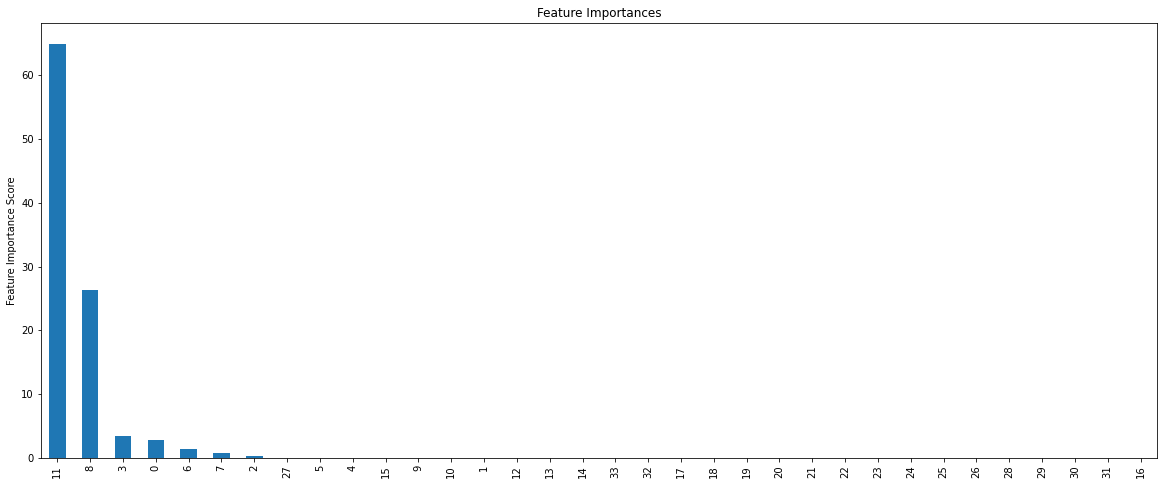

In [95]:
evaluate(model)

In [93]:
pred_test_avg = pred_test2/nsplit
pred_test2 = pred_test_avg[:,1]
pred_test2[:20]

array([0.53959222, 0.51544139, 0.4035332 , 0.36785805, 0.35190068,
       0.45305073, 0.35535131, 0.50926111, 0.3716713 , 0.36785805,
       0.39147152, 0.42016744, 0.27218202, 0.51556178, 0.37115075,
       0.50926111, 0.30948516, 0.25351684, 0.36831628, 0.53959222])

# AVERAGING AND BLENDING

In [ ]:
a47 = pd.read_csv('a47.csv')
a57 = pd.read_csv('a57.csv')
a55 = pd.read_csv('a55.csv')
a51 = pd.read_csv('a51.csv')
a39 = pd.read_csv('a39.csv')

In [99]:
def make_submission(prediction, filename):
    sample = pd.read_csv('sample_submission.csv')
    test = pd.read_csv('Test.csv')
    sample.user_id = test.user_id
    sample.CHURN = prediction
    sample.to_csv(filename, index = False)

BLENDING

In [98]:
a75 = (a57.CHURN * 0.8 + a55.CHURN * 0.2) * 0.7 + (a47.CHURN * 0.3)
make_submission(a75, 'a75.csv')
a75

AVERAGING

In [ ]:
a68 = (a67.CHURN + a66.CHURN + a65.CHURN)/3
make_submission(a68, 'a68.csv')

# MAking a Submission

In [61]:
final_predictions = lr.predict_proba(test_enc1)

In [64]:
#read the submission file in

sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('Test.csv')

In [67]:
sample.user_id = test.user_id
sample.CHURN = final_predictions[:,1]
sample.to_csv('BaselineSubmission.csv', index=False)

In [96]:
def make_submission(prediction, filename):
    sample = pd.read_csv('sample_submission.csv')
    test = pd.read_csv('Test.csv')
    sample.user_id = test.user_id
    sample.CHURN = prediction
    sample.to_csv(filename, index = False)